In [ ]:
!pip install scikit-surprise
!pip install seaborn
!pip install sklearn
!pip install xgboost

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [2]:
def load_data():
    df = pd.read_csv('./scraper/sample_data/qq.txt', header=0, sep=",", names = ["reviewerId","stars","artistId","artistName","albumId","albumName"])
    df1 = df[['albumId', 'reviewerId', 'stars']]
    return df1

In [3]:
prograrchives_df = load_data()
prograrchives_df.head()

,albumId,reviewerId,stars
0,5751,1636,4
1,17838,13226,4
2,1214,21963,4
3,53009,17999,3
4,5331,23451,4


In [4]:
prograrchives_df.loc[prograrchives_df['stars'] == 0]

,albumId,reviewerId,stars
293157,12721,16919,0
296812,14893,18432,0
363732,21877,24690,0
433912,11646,20201,0


In [5]:
print(prograrchives_df.reviewerId.value_counts());
print(prograrchives_df.albumId.value_counts().head());
print(prograrchives_df.stars.value_counts());
total_users = len(np.unique(prograrchives_df["reviewerId"]));
total_albums = len(np.unique(prograrchives_df["albumId"]));
total_reviews = len(prograrchives_df);
print("Total no. of Users = {}".format(total_users))
print("Total no. of Albums = {}".format(total_albums))
print("Total no. of Reviews = {}".format(total_reviews))

20511    7874
21348    6916
22012    6665
3206     5600
6701     5235
         ... 
16211       1
11061       1
4791        1
12723       1
16376       1
Name: reviewerId, Length: 7191, dtype: int64
1827    1236
1510    1142
1903    1073
1440    1073
1441    1059
Name: albumId, dtype: int64
4    187046
3    131096
5    120288
2     49320
1     14098
0         4
Name: stars, dtype: int64
Total no. of Users = 7191
Total no. of Albums = 39539
Total no. of Reviews = 501852


/Users/rommelvillagomez/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


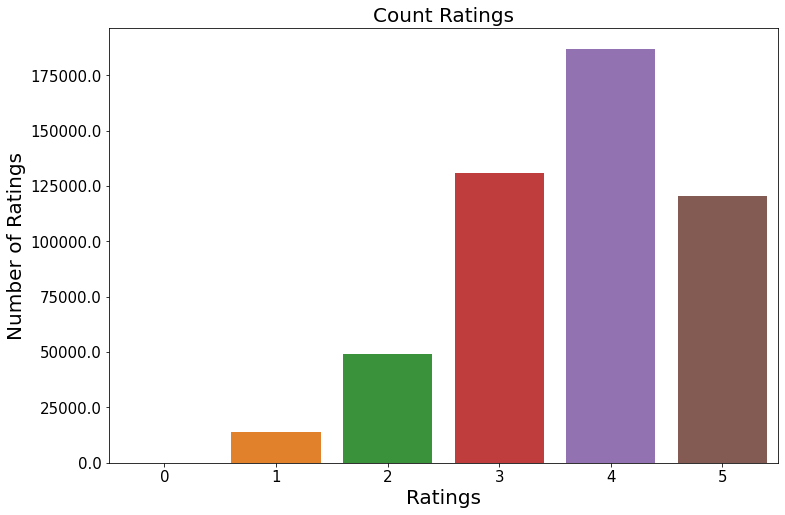

In [62]:
# split_value = int(len(prograrchives_df) * 0.80)
# train_data = prograrchives_df[:split_value]
# test_data = prograrchives_df[split_value:]

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="stars", data=prograrchives_df)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [ ]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.stars, (df.reviewerId, df.albumId)))
    return sparse_data

In [ ]:
sparse_data = get_user_item_sparse_matrix(prograrchives_df);
global_average_rating = sparse_data.sum()/sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

In [ ]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_albums):
    users, albums, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_albums = np.unique(albums)
    np.random.seed(15)
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    album = np.random.choice(uniq_albums, no_of_albums, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(albums, album))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], albums[mask])),
                                                     shape = (max(user)+1, max(album)+1))
    return sparse_matrix

In [ ]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 8, 60)
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 8, 20)
print(train_sample_sparse_matrix)

In [ ]:
row_index, col_index = train_sparse_data.nonzero()
rows = np.unique(row_index)
print(rows);

In [ ]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)

    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar

    return similar_arr